# Investment Portfolio Optimization by Sonan Obin 

#### Importing the libraries 

In [68]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np
from scipy.optimize import minimize

#### Importing our tickers 

In [3]:
tickers = ['VT', 'BNDW', 'GLOF', 'ACWV', 'RSP', 'PDBC', 'GLDM', 'FREL', 'SCHP', 'BIL']

#### Setting our time frame

In [7]:
end_date = datetime.today()
start_date = '2018-01-01'

#### Storing our adjusted close prices in a new DataFrame

In [13]:
adj_close_df = pd.DataFrame()

for ticker in tickers:
    data = yf.download(ticker, start=start_date, end=end_date)
    adj_close_df[ticker] = data['Adj Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


#### Displaying the DataFrame 

In [14]:
print(adj_close_df)

                   VT       BNDW       GLOF        ACWV         RSP  \
Date                                                                  
2018-01-02  66.983360        NaN  27.727699   75.797966   92.492188   
2018-01-03  67.439369        NaN  28.007168   75.995323   92.964752   
2018-01-04  67.841766        NaN  28.081755   76.327255   93.282814   
2018-01-05  68.235207        NaN  28.452883   76.596397   93.728088   
2018-01-08  68.306740        NaN  28.504103   76.641251   94.037071   
...               ...        ...        ...         ...         ...   
2023-05-01  93.290001  68.529999  34.116001   99.669998  145.009995   
2023-05-02  92.239998  69.120003  33.748001   99.129997  142.839996   
2023-05-03  91.919998  69.199997  33.581001   99.050003  142.009995   
2023-05-04  91.599998  69.220001  33.439999   99.070000  140.660004   
2023-05-05  93.160004  68.970001  33.994701  100.000000  143.029999   

                 PDBC       GLDM       FREL       SCHP        BIL  
Date    

#### Calculating the lognormal returns for each ticker 

In [16]:
log_returns = np.log(adj_close_df / adj_close_df.shift(1))

#### Dropping null values from the returns calculation

In [45]:
log_returns = log_returns.dropna()

#### Calculating the covariance matrix using annualized stock returns

In [19]:
cov_matrix = log_returns.cov()*252
print(cov_matrix)

                VT      BNDW          GLOF      ACWV       RSP      PDBC  \
VT    4.492226e-02  0.001951  4.322826e-02  0.030551  0.047268  0.016774   
BNDW  1.951486e-03  0.002677  1.700447e-03  0.002005  0.001655  0.000036   
GLOF  4.322826e-02  0.001700  4.333190e-02  0.029568  0.045940  0.016464   
ACWV  3.055100e-02  0.002005  2.956843e-02  0.024415  0.032996  0.009844   
RSP   4.726842e-02  0.001655  4.594013e-02  0.032996  0.054313  0.018318   
PDBC  1.677431e-02  0.000036  1.646407e-02  0.009844  0.018318  0.041634   
GLDM  3.982705e-03  0.003013  4.265432e-03  0.004842  0.002102  0.007063   
FREL  4.418878e-02  0.003388  4.190196e-02  0.034244  0.051347  0.014822   
SCHP  1.189232e-03  0.002459  1.059176e-03  0.001070  0.000694  0.002667   
BIL  -4.137506e-07  0.000006 -2.577794e-07  0.000006 -0.000006 -0.000026   

          GLDM      FREL          SCHP           BIL  
VT    0.003983  0.044189  1.189232e-03 -4.137506e-07  
BNDW  0.003013  0.003388  2.459126e-03  5.630081e-06 

#### The output above shows the correlation between each of the assets 

#### Calculating the portfolio performance metrics 

In [26]:
# Standard deviation

def standard_deviation (weights, cov_matrix): 
    variance = weights.T @cov_matrix @weights
    return np.sqrt(variance)

In [27]:
# Expected return

def expected_return (weights, log_returns): 
    return np.sum(log_returns.mean()*weights)*252

In [64]:
# Sharpe Ratio 

def sharpe_ratio (weights, log_returns, cov_matrix, risk_free_rate):
    return(expected_return (weights, log_returns)-risk_free_rate) / standard_deviation (weights, cov_matrix)

#### Setting the risk-free rate

In [62]:
from fredapi import Fred 

#Import FRED api_key 

fred = Fred(api_key='d017a954d53548a26bdfae9542aeb954')
ten_year_treasury_rate = fred.get_series_latest_release('GS10') / 100

#Set the risk-free rate 
risk_free_rate = ten_year_treasury_rate.iloc[-1]
print(risk_free_rate)

0.0346


#### Defining the function to minimize (negative sharpe ratio)

In [61]:
def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

#### Setting the constraints and bounds 

In [60]:
constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
bounds = [(0, 0.5) for _ in range(len(tickers))]

#### Setting the initial weights

In [54]:
initial_weights = np.array([1/len(tickers)]*len(tickers))
print(initial_weights)

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


#### Optimizing the weights to maximize Sharpe Ratio 

In [65]:
optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)

#### Getting the optimal weights

In [66]:
optimal_weights = optimized_results.x

#### Displaying the analytics of the optimal portfolio 

In [67]:
print('optimal_weights:')
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:4f}")
    
print()
    
optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:4f}")

optimal_weights:
VT: 0.000000
BNDW: 0.000000
GLOF: 0.000000
ACWV: 0.000000
RSP: 0.225828
PDBC: 0.116050
GLDM: 0.500000
FREL: 0.000000
SCHP: 0.158122
BIL: 0.000000

Expected Annual Return: 0.086349
Expected Volatility: 0.110196
Sharpe Ratio: 0.469614


#### Plotting the optimal portfolio

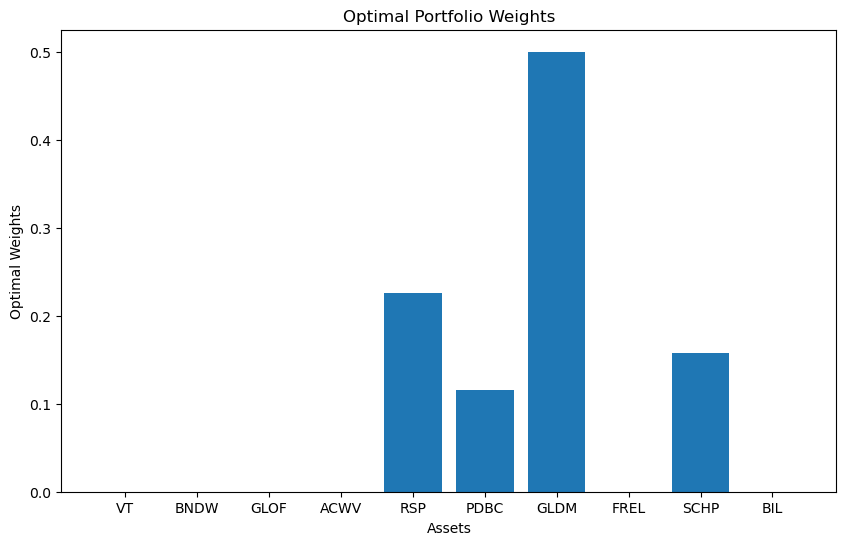

In [69]:
plt.figure(figsize = (10,6))
plt.bar(tickers, optimal_weights)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

plt.show()